#### Цель данной работы - определить, данные с каких датчиков наиболее способствуют классификации болезни Паркинсона.

Поскольку датчики крепятся с двух сторон, одному датчику соответсвует пара признаков. Всего исходный набор данный содержит 9 пар признаков.

Для достижения поставленной цели будет произведен итеративный отбор признаков жадным образом через отбрасывание наименее важной пары признаков на каждом шаге.

Отбор будет произведен по критерию изменения среднего значения метрики ROC-AUC на кросс-валидации.

Метрики качества итоговой модели будут измерены на отложенном наборе данных.

#### Импорт библиотек

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
strategy = tf.distribute.MirroredStrategy()

2025-06-13 12:11:39.173215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749816699.354900      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749816699.405414      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1749816712.347080      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uuid
import json
from IPython.display import clear_output
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Masking, Conv1D, BatchNormalization, Dropout, MaxPooling1D, LSTM, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

#### Определение функций

In [3]:
def load_data(folder, num_steps=8192, num_features=18):    
    target = pd.read_csv(f'{folder}target.csv', header=None, sep='-')
    target.columns=['filename','target']
    X = np.zeros([len(target), num_steps, num_features])
    Y = np.array(target.target)
    for i, filename in enumerate(target.filename):
        df = pd.read_csv(f'{folder}{filename}_01.csv',header=None)
        min_len = min(num_steps,len(df))
        X[i, :min_len, :] = df.iloc[:num_steps,1:]
    return X, Y

In [4]:
def build_model(max_timesteps, n_features, use_masking=False):
    inputs = Input(shape=(max_timesteps, n_features))
    x = inputs
    for filters in [32, 64, 128, 128]:
        x = Conv1D(filters, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = MaxPooling1D(2)(x)
    if use_masking:
        x = Masking(mask_value=0.0)(x)
    x = LSTM(64)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy',metrics=['acc'])
    return model

def train_ensemble(X, y, n_fold=5, epochs=150, batch_size=12):
    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)
    models, aucs, accs = [], [], []
    if not os.path.exists('models/'):
        os.mkdir('models/')
    for train_idx, val_idx in skf.split(X, y):
        K.clear_session()
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model = build_model(X.shape[1], X.shape[2], use_masking=True)
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[EarlyStopping('val_acc', mode='max', patience=75, restore_best_weights=True)],
            verbose=False)
        save_path = f"models/model_{uuid.uuid4().hex}.keras"
        model.save(save_path)
        y_pred = model.predict(X_val).flatten()
        models.append(save_path)
        aucs.append(roc_auc_score(y_val, y_pred))
        accs.append(accuracy_score(y_val, y_pred > 0.5))
    return np.mean(aucs), models, aucs, accs

def get_models_and_indices(removal_log, feature_groups):
    groups = feature_groups.copy()
    best_log = max(removal_log, key=lambda x: x[2])
    for log in removal_log:
        group, *_ = log
        if group:
            groups.remove(group)
        if log == best_log:
            break
    return best_log[5], sorted(np.array(groups).flatten())

def load_ensemble(save_paths):
    models = []
    for save_path in save_paths:
        models.append(load_model(save_path))
    return models

def predict(X, models):
    predictions = []
    for model in models:
        predictions.append(model.predict(X))
    return np.mean(predictions, axis=0)

In [6]:
def feature_removal(X, y, feature_groups, n_fold=5, epochs=150, batch_size=12, min_thresh=0.9):
    orig_groups = [list(g) for g in feature_groups]
    orig_dim = X.shape[2]
    X_full = X.copy()
    active_indices = list(range(orig_dim))
    initial_score, models, aucs, accs = train_ensemble(X, y, n_fold, epochs, batch_size)
    threshold = initial_score * min_thresh
    print(f"Initial AUC: {initial_score:.4f}, stopping threshold: {threshold:.4f}")
    best_score = initial_score
    removal_log = [(None, 0.0, initial_score, aucs, accs, models, orig_groups, len(orig_groups))]
    remaining_groups = orig_groups.copy()
    while len(remaining_groups) > 1:
        drops = []
        for group in remaining_groups:
            pos_to_remove = [active_indices.index(idx) for idx in group if idx in active_indices]
            if not pos_to_remove:
                continue
            mask = np.ones(len(active_indices), dtype=bool)
            mask[pos_to_remove] = False
            X_reduced = X[:, :, mask]
            score, models, aucs, accs = train_ensemble(X_reduced, y, n_fold, epochs, batch_size)
            drops.append((group, best_score - score, score, models, aucs, accs))
        group_to_remove, drop, new_score, models, aucs, accs = min(drops, key=lambda x: x[1])
        if new_score < threshold:
            print(f"Stop removal: removing {group_to_remove} lowers AUC below threshold ({new_score:.4f} < {threshold:.4f})")
            break
        print(f"Removing group {group_to_remove}: drop {drop:.4f}, AUC {new_score:.4f}, ACC {np.mean(accs):.4f}")
        for idx in group_to_remove:
            if idx in active_indices:
                active_indices.remove(idx)
        X = X_full[:, :, active_indices]
        best_score = max(best_score, new_score)
        threshold = best_score * min_thresh
        remaining_groups.remove(group_to_remove)
        removal_log.append((group_to_remove, drop, new_score, aucs, accs, models, remaining_groups, len(remaining_groups)))
    return removal_log

#### Отбор признаков

In [7]:
X, y = load_data('/kaggle/input/parkinson-1/csv/csv/', num_steps=8192, num_features=18)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.18, stratify=y, random_state=42)

In [8]:
feature_groups = [[0,8], [1,9], [2,10], [3,11], [4,12], [5,13], [6,14], [7,15], [16,17]]

removal_log = feature_removal(X_train_full, y_train_full, feature_groups, n_fold=5, min_thresh=0.8)

clear_output()
print("Feature removal sequence:")
for group, drop, score, *_ in removal_log:
    print(f"Group {group} removed: AUC drop {drop:.4f}, new AUC {score:.4f}")

Feature removal sequence:
Group None removed: AUC drop 0.0000, new AUC 0.6995
Group [3, 11] removed: AUC drop -0.1007, new AUC 0.8002
Group [1, 9] removed: AUC drop 0.0210, new AUC 0.7792
Group [7, 15] removed: AUC drop 0.0299, new AUC 0.7703
Group [16, 17] removed: AUC drop 0.0546, new AUC 0.7456
Group [0, 8] removed: AUC drop -0.0097, new AUC 0.8099
Group [2, 10] removed: AUC drop -0.0182, new AUC 0.8281
Group [5, 13] removed: AUC drop 0.1278, new AUC 0.7004
Group [4, 12] removed: AUC drop 0.0947, new AUC 0.7334


In [84]:
with open('removal_log.json','w') as f:
    json.dump(removal_log, f)

#### Визуализация результатов

In [129]:
def plot_removal_performance(removal_log):

    groups_remaining = [log[7] for log in removal_log] 
    auc_values = [log[2] for log in removal_log]       
    acc_values = [np.mean(log[4]) for log in removal_log]
    removed_groups = [str(log[0]) if log[0] is not None else "Start" for log in removal_log]
    max_auc = max(auc_values)
    max_acc = max(acc_values)
    
    fig, ax1 = plt.subplots(figsize=(14, 10))
    color_auc = 'tab:red'
    ax1.set_xlabel('Number of feature groups remaining', fontsize=10)
    ax1.set_ylabel('ROC-AUC', color=color_auc, fontsize=10)
    auc_line = ax1.plot(groups_remaining, auc_values, 'o-', color=color_auc, 
        linewidth=2, markersize=8, label='ROC-AUC')
    ax1.tick_params(axis='y', labelcolor=color_auc)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    ax1.axhline(y=max_auc, color=color_auc, linestyle=':', linewidth=2, alpha=0.7)
    ax1.annotate(f'Max ROC-AUC: {max_auc:.4f}', xy=(groups_remaining[0], max_auc),
        xytext=(-10, -15), textcoords='offset points', color=color_auc, fontsize=10)

    ax2 = ax1.twinx()
    color_acc = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color_acc, fontsize=10)
    acc_line = ax2.plot(groups_remaining, acc_values, 's-', 
        color=color_acc, linewidth=2, markersize=8, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color_acc)
    
    ax2.axhline(y=max_acc, color=color_acc, linestyle=':', linewidth=2, alpha=0.7)
    ax2.annotate(f'Max Accuracy: {max_acc:.4f}', xy=(groups_remaining[-1], max_acc),
        xytext=(10, -15), textcoords='offset points', color=color_acc, fontsize=10, ha='right')
    
    for i, (x, y_auc, y_acc, group) in enumerate(zip(groups_remaining, auc_values, acc_values, removed_groups)):
        ax1.annotate(group, xy=(x, y_auc), xytext=(0, 15), textcoords='offset points', ha='center', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=0.5, alpha=0.8))
    
    lines = auc_line + acc_line
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='lower center', fontsize=10)
    ax1.set_xticks(groups_remaining)
    ax1.set_xticklabels(groups_remaining, fontsize=10)
    ax1.set_xlim(groups_remaining[-1] - 0.5, groups_remaining[0] + 0.5)
    ax1.invert_xaxis()
    fig.tight_layout()
    plt.show()

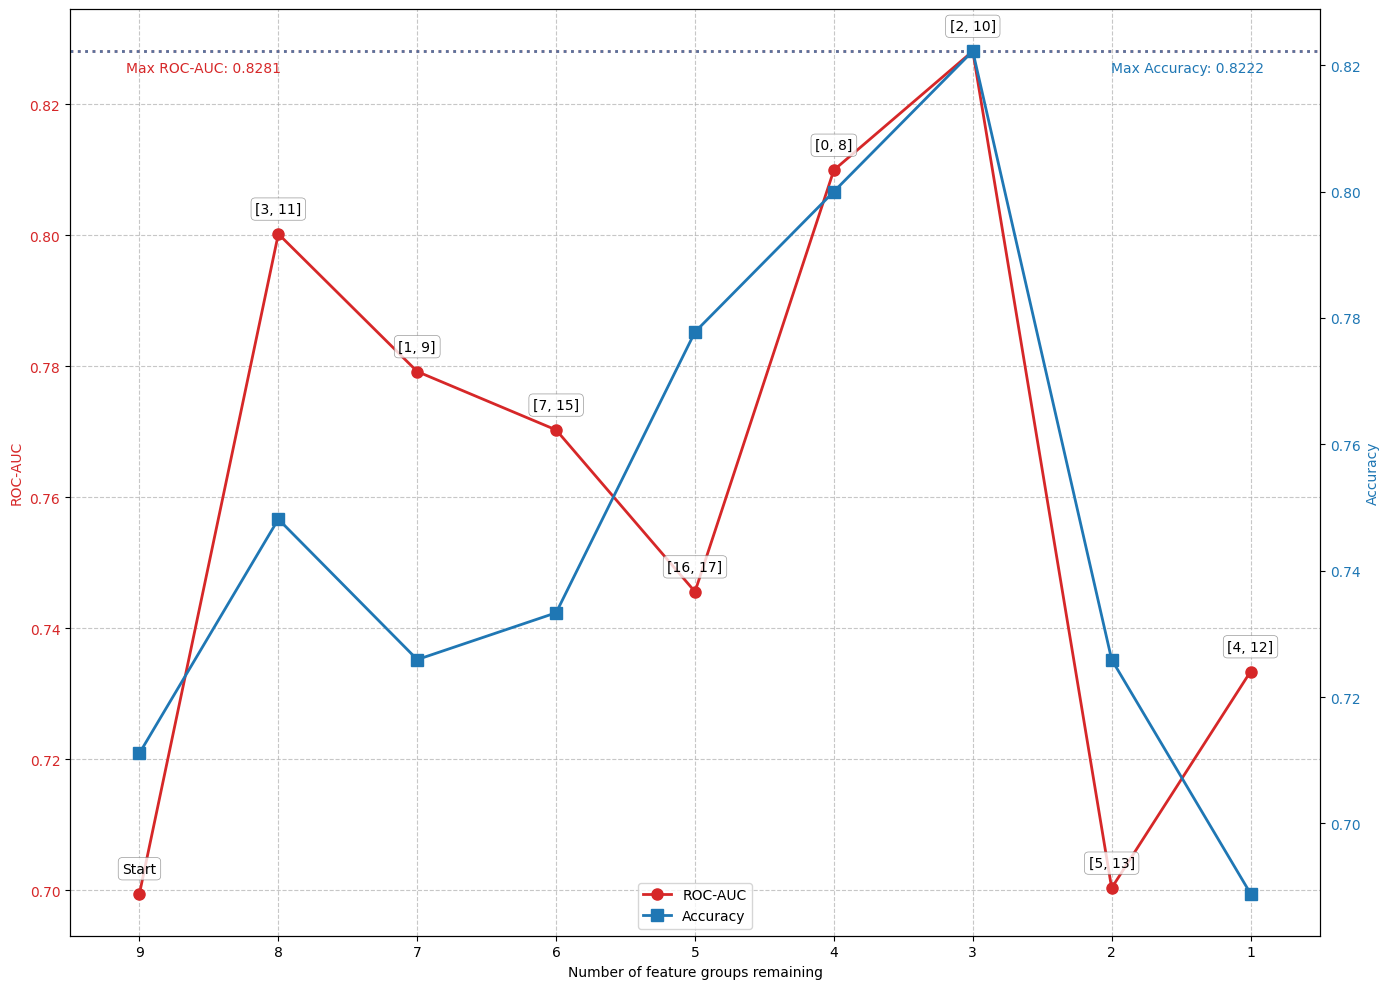

In [130]:
plot_removal_performance(removal_log)

Таким образом, датчики [4, 12], [5, 13], [6,14] способствуют построению ансамбля моделей с наилучшим качеством классификации. 

#### Тестирование на отложенной выборке

In [202]:
model_paths, features = get_models_and_indices(removal_log, feature_groups)

In [203]:
models = load_ensemble(model_paths)
y_pred = predict(X_test[:,:,features],models)
print(f'Accuracy on test data: {accuracy_score(y_test, y_pred>0.5):.4f}')
print(f'Precision on test data: {precision_score(y_test, y_pred>0.5):.4f}')
print(f'Recall on test data: {recall_score(y_test, y_pred>0.5):.4f}')
print(f'F1 on test data: {f1_score(y_test, y_pred>0.5):.4f}')
print(f'ROC-AUC on test data: {roc_auc_score(y_test, y_pred):.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Accuracy on test data: 0.7000
Precision on test data: 0.7500
Recall on test data: 0.7059
F1 on test data: 0.7273
ROC-AUC on test data: 0.8009


#### Пересохранение лучшего ансамбля и индексов признаков

In [204]:
os.mkdir('best_models/')
for i, model in enumerate(models):
    save_path = f"best_models/model_{i}.keras"
    model.save(save_path)

In [217]:
with open('features_indices.txt','w') as f:
    f.write(' '.join([str(i) for i in features]))

In [218]:
np.save('X_train.npy', X_train_full)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train_full)
np.save('y_test.npy', y_test)